In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Train.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import h5py
from tqdm import tqdm

import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

global_batch_size = 128 #128

/admin/home-conscioustahoe/miniconda3/envs/fmri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-08 18:29:07,891] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

accelerator = Accelerator(split_batches=False)

### UNCOMMENT BELOW STUFF TO USE DEEPSPEED (also comment out the immediately above "accelerator = " line) ###

# if num_devices <= 1 and utils.is_interactive():
#     # can emulate a distributed environment for deepspeed to work in jupyter notebook
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
#     os.environ["RANK"] = "0"
#     os.environ["LOCAL_RANK"] = "0"
#     os.environ["WORLD_SIZE"] = "1"
#     os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
#     global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]

# # alter the deepspeed config according to your global and local batch size
# if local_rank == 0:
#     with open('deepspeed_config_stage2.json', 'r') as file:
#         config = json.load(file)
#     config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
#     config['train_micro_batch_size_per_gpu'] = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices
#     with open('deepspeed_config_stage2.json', 'w') as file:
#         json.dump(config, file)
# else:
#     # give some time for the local_rank=0 gpu to prep new deepspeed config file
#     time.sleep(10)
# deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2.json")
# accelerator = Accelerator(split_batches=False, deepspeed_plugin=deepspeed_plugin)

LOCAL RANK  0


In [4]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

PID of this process = 656428
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1


# Configurations

In [5]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name=test \
                    --subj=1 --batch_size={global_batch_size} --n_samples_save=0 \
                    --max_lr=3e-5 --mixup_pct=0 --num_epochs=18 --ckpt_interval=999 --no-use_image_aug"

    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

['--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset', '--model_name=test', '--subj=1', '--batch_size=128', '--n_samples_save=0', '--max_lr=3e-5', '--mixup_pct=0', '--num_epochs=18', '--ckpt_interval=999', '--no-use_image_aug']


In [6]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=240,
    help="number of epochs of training",
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)
parser.add_argument(
    "--n_samples_save",type=int,default=0,choices=[0,1],
    help="Number of reconstructions for monitoring progress, 0 will speed up training",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

print("global batch_size", batch_size)
batch_size = int(batch_size / num_devices)
print("batch_size", batch_size)

global batch_size 128
batch_size 128


In [7]:
outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir):
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

In [8]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the current GPU device
    device = torch.cuda.current_device()
    # Get the available memory on the GPU
    available_memory = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # in GiB
    # Get the GPU memory currently in use by PyTorch
    current_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GiB
    # Get the GPU memory currently cached by PyTorch (may be released if needed)
    cached_memory = torch.cuda.memory_reserved(device) / (1024 ** 3)  # in GiB

    print(f"Available GPU Memory: {available_memory:.2f} GiB")
    print(f"Current GPU Memory Used: {current_memory:.2f} GiB")
    print(f"GPU Memory Cached: {cached_memory:.2f} GiB")
else:
    print("CUDA is not available.")

Available GPU Memory: 39.56 GiB
Current GPU Memory Used: 0.00 GiB
GPU Memory Cached: 0.00 GiB


# Prep data, models, and dataloaders

## Dataloader

In [9]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..2}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True)

test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)

test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=False, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..2}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


### check dataloaders are working

In [10]:
# test_indices = []
# test_images = []
# for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
#     test_indices = np.append(test_indices, behav[:,0,5].numpy())
#     test_images = np.append(test_images, behav[:,0,0].numpy())
# test_indices = test_indices.astype(np.int16)
# print(test_i, (test_i+1) * test_batch_size, len(test_indices))
# print("---\n")

# train_indices = []
# train_images = []
# for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
#     train_indices = np.append(train_indices, behav[:,0,5].long().numpy())
#     train_images = np.append(train_images, behav[:,0,0].numpy())
# train_indices = train_indices.astype(np.int16)
# print(train_i, (train_i+1) * batch_size, len(train_indices))

# # train_images = np.hstack((train_images, test_images))
# # print("WARNING: ADDED TEST IMAGES TO TRAIN IMAGES")

## Load data and images

In [11]:
# load betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')
voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").half()
if subj==1:
    voxels = torch.hstack((voxels, torch.zeros((len(voxels), 5))))
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").half()
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15729])
images torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [12]:
from models import Clipper
clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)

clip_seq_dim = 257
clip_emb_dim = 768
hidden_dim = 4096

ViT-L/14 cuda:0


### SD VAE (blurry images)

In [13]:
from diffusers import AutoencoderKL
autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
# autoenc.load_state_dict(torch.load('../train_logs/sdxl_vae_normed/best.pth')["model_state_dict"])
autoenc.eval()
autoenc.requires_grad_(False)
autoenc.to(device)
utils.count_params(autoenc)

param counts:
83,653,863 total
0 trainable


### MindEye modules

In [14]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [15]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_size, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        return self.linear(x)
        
model.ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

b = torch.randn((2,1,voxels.shape[1]))
print(b.shape, model.ridge(b).shape)

param counts:
64,430,080 total
64,430,080 trainable
param counts:
64,430,080 total
64,430,080 trainable
torch.Size([2, 1, 15729]) torch.Size([2, 1, 4096])


In [16]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, out_dim=768, in_dim=15724, clip_size=768, h=4096, n_blocks=4, norm_type='ln', act_first=False, drop=.15, blurry_dim=16):
        super().__init__()
        self.blurry_dim = blurry_dim
        norm_func = partial(nn.BatchNorm1d, num_features=h) if norm_type == 'bn' else partial(nn.LayerNorm, normalized_shape=h)
        act_fn = partial(nn.ReLU, inplace=True) if norm_type == 'bn' else nn.GELU
        act_and_norm = (act_fn, norm_func) if act_first else (norm_func, act_fn)
        self.lin0 = nn.Linear(in_dim, h)
        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h),
                *[item() for item in act_and_norm],
                nn.Dropout(drop)
            ) for _ in range(n_blocks)
        ])
        self.lin1 = nn.Linear(h, out_dim, bias=True)
        self.blin1 = nn.Linear(out_dim, blurry_dim, bias=True)
        self.n_blocks = n_blocks
        self.clip_size = clip_size
        self.clip_proj = nn.Sequential(
            nn.LayerNorm(clip_size),
            nn.GELU(),
            nn.Linear(clip_size, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, clip_size)
        )
        self.upsampler = Decoder(
                in_channels=64,
                out_channels=4,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[64, 128, 256],
                layers_per_block=1,
            )
        self.temp = nn.Parameter(torch.ones([]) * 5.3)
        self.bias = nn.Parameter(torch.ones([]) * (-2))
        
    def forward(self, x):
        x = self.lin0(x)
        residual = x
        for res_block in range(self.n_blocks):
            x = self.mlp[res_block](x)
            x += residual
            residual = x
        x = x.reshape(len(x), -1)
        x = self.lin1(x)
        b = self.blin1(x)
        b = self.upsampler(b.reshape(len(b), -1, 7, 7))
        c = self.clip_proj(x.reshape(len(x), -1, self.clip_size))
        return c, b

model.backbone = BrainNetwork(h=2048, in_dim=hidden_dim, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, blurry_dim=64*7*7) 
utils.count_params(model.backbone)
utils.count_params(model)

b = torch.randn((2,hidden_dim))
print(b.shape)
clip_, blur_ = model.backbone(b)
print(clip_.shape, blur_.shape)

param counts:
1,062,786,438 total
1,062,786,438 trainable
param counts:
1,127,216,518 total
1,127,216,518 trainable
torch.Size([2, 4096])
torch.Size([2, 257, 768]) torch.Size([2, 4, 28, 28])


In [17]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr, betas=(0.9, 0.95))

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(num_epochs*(num_train*num_devices//batch_size)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(num_epochs*(num_train*num_devices//batch_size))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):    
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(model)
    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    except:
        print("Couldn't save... moving on to prevent crashing.")
    del unwrapped_model
        
print("\nDone with model preparations!")
utils.count_params(model)


Done with model preparations!
param counts:
1,127,216,518 total
1,127,216,518 trainable


# Weights and Biases

In [18]:
# params for wandb
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    
    wandb_project = 'stability'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "clip_variant": clip_variant,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "lr_scheduler_type": lr_scheduler_type,
      "mixup_pct": mixup_pct,
      "num_train": num_train,
      "num_test": num_test,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

# More custom functions

In [19]:
# using the same preprocessing as was used in MindEye + BrainDiffuser
pixcorr_preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])
def pixcorr(images,brains):
    # Flatten images while keeping the batch dimension
    all_images_flattened = pixcorr_preprocess(images).reshape(len(images), -1)
    all_brain_recons_flattened = pixcorr_preprocess(brains).view(len(brains), -1)
    corrmean = torch.diag(utils.batchwise_pearson_correlation(all_images_flattened, all_brain_recons_flattened)).mean()
    return corrmean

# Main

In [20]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    try:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    except:
        print('last.pth failed... trying last_backup.pth')
        checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
    epoch = checkpoint['epoch']
    print("Epoch",epoch)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    diffusion_diffuser.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
elif wandb_log:
    if wandb.run.resumed:
        print("\n---resuming from last.pth ckpt---\n")
        try:
            checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        except:
            print('last.pth failed... trying last_backup.pth')
            checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
        epoch = checkpoint['epoch']
        print("Epoch",epoch)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        diffusion_diffuser.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
torch.cuda.empty_cache()

In [21]:
model, optimizer, train_dl, test_dl, lr_scheduler = accelerator.prepare(
model, optimizer, train_dl, test_dl, lr_scheduler
)

test starting with epoch 0 / 18


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

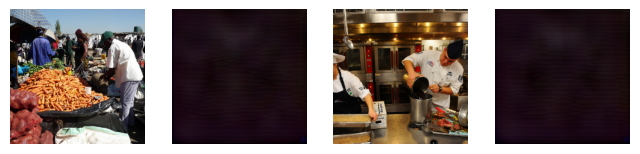

  6%|████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 1/18 [00:40<11:23, 40.20s/it, test/blurry_pixcorr=tensor(0.0247, device='cuda:0', dtype=torch.float16), test/loss=46.1, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=1, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0300, device='cuda:0'), train/blurry_pixcorr=tensor(0.0531, device='cuda:0', dtype=torch.float16), train/bwd_pct_correc

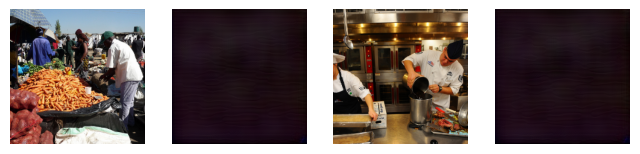

 11%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 2/18 [00:59<07:27, 27.98s/it, test/blurry_pixcorr=tensor(0.0286, device='cuda:0', dtype=torch.float16), test/loss=44.4, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=2, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0400, device='cuda:0'), train/blurry_pixcorr=tensor(0.0737, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=

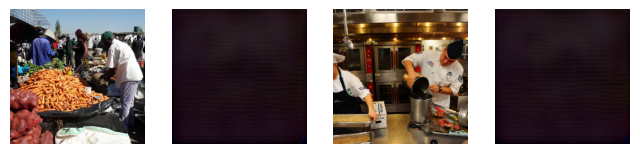

 17%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 3/18 [01:19<06:00, 24.06s/it, test/blurry_pixcorr=tensor(0.0397, device='cuda:0', dtype=torch.float16), test/loss=43.1, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=3, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0100, device='cuda:0'), train/blurry_pixcorr=tensor(0.1395, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=

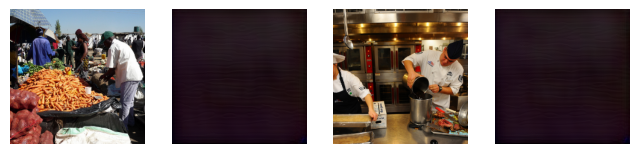

 22%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 4/18 [01:38<05:10, 22.20s/it, test/blurry_pixcorr=tensor(0.0483, device='cuda:0', dtype=torch.float16), test/loss=42.8, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=4, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0100, device='cuda:0'), train/blurry_pixcorr=tensor(0.0909, device='cuda:0', dtype=torch.float16), train/bwd_pct_corr

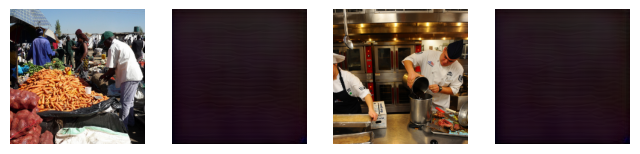

 28%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                           | 5/18 [01:57<04:35, 21.18s/it, test/blurry_pixcorr=tensor(0.0497, device='cuda:0', dtype=torch.float16), test/loss=42.6, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=5, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0100, device='cuda:0'), train/blurry_pixcorr=tensor(0.0729, device='cuda:0', dtype=torch.float16), train/bwd_pct_correc

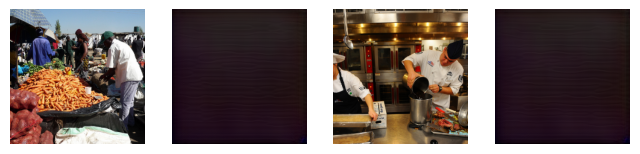

 33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                        | 6/18 [02:17<04:07, 20.59s/it, test/blurry_pixcorr=tensor(0.0541, device='cuda:0', dtype=torch.float16), test/loss=42.1, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=6, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0100, device='cuda:0'), train/blurry_pixcorr=tensor(0.0957, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

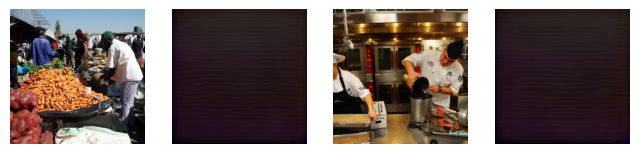

 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                        | 7/18 [02:36<03:41, 20.18s/it, test/blurry_pixcorr=tensor(0.0679, device='cuda:0', dtype=torch.float16), test/loss=41.7, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=7, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0300, device='cuda:0'), train/blurry_pixcorr=tensor(0.0820, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

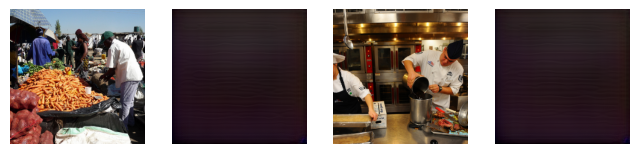

 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                       | 8/18 [02:55<03:19, 19.94s/it, test/blurry_pixcorr=tensor(0.0792, device='cuda:0', dtype=torch.float16), test/loss=41.4, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=8, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0500, device='cuda:0'), train/blurry_pixcorr=tensor(0.1307, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

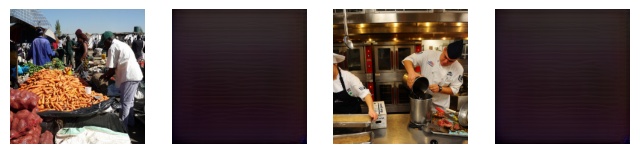

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                         | 9/18 [03:15<02:57, 19.75s/it, test/blurry_pixcorr=tensor(0.0960, device='cuda:0', dtype=torch.float16), test/loss=41, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=9, test/test_bwd_pct_correct=tensor(0.0200, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0300, device='cuda:0'), train/blurry_pixcorr=tensor(0.1377, device='cuda:0', dtype=torch.float16), train/bwd_pct_correc

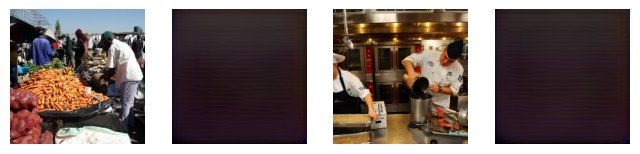

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 10/18 [03:34<02:37, 19.63s/it, test/blurry_pixcorr=tensor(0.1158, device='cuda:0', dtype=torch.float16), test/loss=40.9, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=10, test/test_bwd_pct_correct=tensor(0.0100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0700, device='cuda:0'), train/blurry_pixcorr=tensor(0.1633, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct

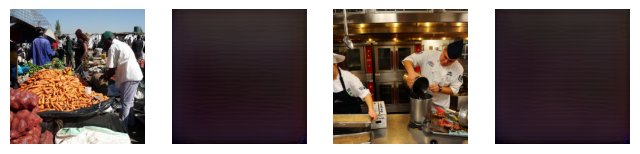

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                     | 11/18 [03:54<02:16, 19.57s/it, test/blurry_pixcorr=tensor(0.1392, device='cuda:0', dtype=torch.float16), test/loss=41, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=11, test/test_bwd_pct_correct=tensor(0.0400, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0800, device='cuda:0'), train/blurry_pixcorr=tensor(0.0876, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=

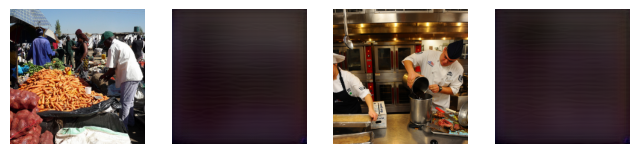

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 12/18 [04:13<01:57, 19.50s/it, test/blurry_pixcorr=tensor(0.1719, device='cuda:0', dtype=torch.float16), test/loss=41.3, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=12, test/test_bwd_pct_correct=tensor(0.0800, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0700, device='cuda:0'), train/blurry_pixcorr=tensor(0.1797, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct

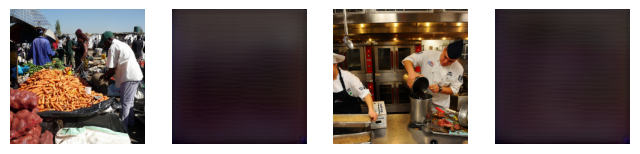

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 13/18 [04:32<01:37, 19.46s/it, test/blurry_pixcorr=tensor(0.1686, device='cuda:0', dtype=torch.float16), test/loss=41.3, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=13, test/test_bwd_pct_correct=tensor(0.0700, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0900, device='cuda:0'), train/blurry_pixcorr=tensor(0.1969, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

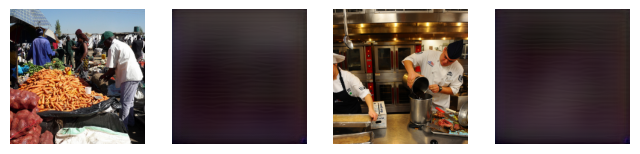

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 14/18 [04:52<01:17, 19.44s/it, test/blurry_pixcorr=tensor(0.2000, device='cuda:0', dtype=torch.float16), test/loss=40.4, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=14, test/test_bwd_pct_correct=tensor(0.1000, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0700, device='cuda:0'), train/blurry_pixcorr=tensor(0.2563, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

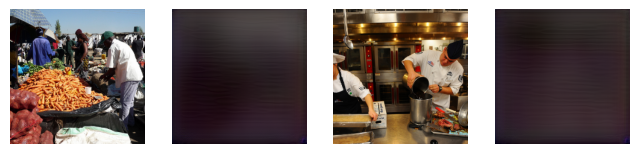

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 15/18 [05:11<00:58, 19.41s/it, test/blurry_pixcorr=tensor(0.2028, device='cuda:0', dtype=torch.float16), test/loss=38.4, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=15, test/test_bwd_pct_correct=tensor(0.0800, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.0900, device='cuda:0'), train/blurry_pixcorr=tensor(0.1982, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

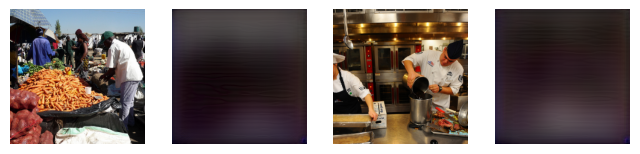

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/18 [05:30<00:38, 19.42s/it, test/blurry_pixcorr=tensor(0.1937, device='cuda:0', dtype=torch.float16), test/loss=38.1, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=16, test/test_bwd_pct_correct=tensor(0.1400, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.1500, device='cuda:0'), train/blurry_pixcorr=tensor(0.3293, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

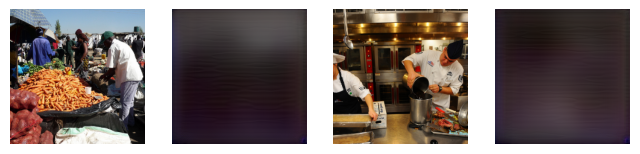

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 17/18 [05:50<00:19, 19.40s/it, test/blurry_pixcorr=tensor(0.2183, device='cuda:0', dtype=torch.float16), test/loss=38.1, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=17, test/test_bwd_pct_correct=tensor(0.1100, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.1400, device='cuda:0'), train/blurry_pixcorr=tensor(0.2032, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t

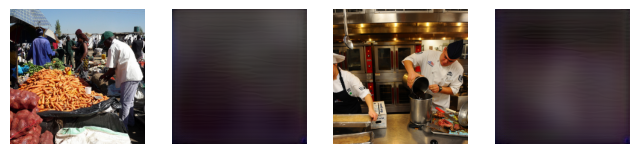

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [06:09<00:00, 20.54s/it, test/blurry_pixcorr=tensor(0.1941, device='cuda:0', dtype=torch.float16), test/loss=36.9, test/loss_blurry_total=0, test/loss_clip_total=0, test/num_steps=18, test/test_bwd_pct_correct=tensor(0.1400, device='cuda:0'), test/test_fwd_pct_correct=tensor(0.2200, device='cuda:0'), train/blurry_pixcorr=tensor(0.3516, device='cuda:0', dtype=torch.float16), train/bwd_pct_correct=t


===Finished!===

saving /fsx/proj-fmri/conscioustahoe/MindEyeV2/train_logs/test/last.pth


In [22]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
for epoch in progress_bar:
    torch.cuda.empty_cache()
    model.train()
    
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    test_loss_clip_total = 0.
    test_loss_blurry_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1
    
    for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
        with torch.cuda.amp.autocast():
            optimizer.zero_grad()

            voxel = voxels[behav[:,0,5].cpu().long()].to(device)
            
            image = images[behav[:,0,0].cpu().long()].to(device).float()

            blurry_image_enc = autoenc.encode(image).latent_dist.mode()
            
            if use_image_aug: image = img_augment(image)
            
            clip_target = clip_model.embed_image(image)
            assert not torch.any(torch.isnan(clip_target))
  
            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel)
            
            clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
            
            clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if epoch < int(mixup_pct * num_epochs):                
                loss_clip = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006, 
                    perm=perm, betas=betas, select=select)
            else:
                epoch_temp = model.backbone.temp
                epoch_bias = model.backbone.bias
                # voxel, perm, betas, select = utils.mixco(voxel)
                loss_clip = utils.soft_siglip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp,
                    bias=epoch_bias
                )

            loss_blurry = mse(blurry_image_enc_, blurry_image_enc) 

            loss_clip_total += loss_clip.item()
            loss_blurry_total += loss_blurry.item()

            loss = loss_blurry + loss_clip
            
            utils.check_loss(loss)

            accelerator.backward(loss)
            optimizer.step()
    
            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])
    
            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
            fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1)
            bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1)

            with torch.no_grad():
                # only doing pixcorr eval on a subset (8) of the samples per batch because its costly & slow to compute autoenc.decode()
                random_samps = np.random.choice(np.arange(len(voxel)), size=1, replace=False)
                blurry_recon_images = autoenc.decode(blurry_image_enc_[random_samps]).sample.clamp(0,1)
                blurry_pixcorr += pixcorr(image[random_samps], blurry_recon_images)

            if lr_scheduler_type is not None:
                lr_scheduler.step()
    
    model.eval()
    for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
        with torch.cuda.amp.autocast():
            with torch.no_grad():   
                # all test samples should be loaded per batch such that test_i should never exceed 0
                if len(behav) != num_test: print("!",len(behav),num_test)
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[behav[:,0,5].cpu().long()].to(device)
                    
                    image = behav[:,0,0].cpu().long()
                    
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = torch.mean(voxel[locs],axis=0)[None]
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
    
                # sample of batch_size
                random_indices = torch.arange(len(test_voxel))[:100] #torch.randperm(len(test_voxel))[:300]
                voxel = test_voxel[random_indices].to(device)
                image = test_image[random_indices].to(device)
                assert len(image) == 100

                blurry_image_enc = autoenc.encode(image).latent_dist.mode()
        
                clip_target = clip_model.embed_image(image.float())
    
                voxel_ridge = model.ridge(voxel)
                
                clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
                
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

                epoch_temp = model.backbone.temp
                epoch_bias = model.backbone.bias
                
                loss_clip = utils.soft_siglip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp,
                    bias=epoch_bias
                )

                loss_blurry = mse(blurry_image_enc_, blurry_image_enc)
                
                loss = loss_blurry + loss_clip
                
                utils.check_loss(loss)
        
                test_losses.append(loss.item())
        
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_target_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1)
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1)

                # halving the batch size because the decoder is computationally heavy
                blurry_recon_images = autoenc.decode(blurry_image_enc_[:len(voxel)//2]).sample.clamp(0,1)
                blurry_recon_images = torch.vstack((blurry_recon_images, autoenc.decode(blurry_image_enc_[len(voxel)//2:]).sample.clamp(0,1)))
                test_blurry_pixcorr += pixcorr(image, blurry_recon_images)

                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 4, figsize=(8, 4))
                axes[0].imshow(utils.torch_to_Image(image[[0]]))
                axes[1].imshow(utils.torch_to_Image(autoenc.decode(blurry_image_enc_[[0]]).sample.clamp(0,1)))
                axes[2].imshow(utils.torch_to_Image(image[[1]]))
                axes[3].imshow(utils.torch_to_Image(autoenc.decode(blurry_image_enc_[[1]]).sample.clamp(0,1)))
                axes[0].axis('off'); axes[1].axis('off'); axes[2].axis('off'); axes[3].axis('off')
                plt.show()

    if local_rank==0:      
        # if utils.is_interactive(): clear_output(wait=True)
        assert (test_i+1) == 1
        logs = {"train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": np.mean(test_losses[-(test_i+1):]),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
            "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
            "test/loss_blurry_total": test_loss_blurry_total / (test_i + 1),
            "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
            "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
            }
        progress_bar.set_postfix(**logs)

        # Save model checkpoint and reconstruct
        if epoch % ckpt_interval == 0:
            if not utils.is_interactive():
                save_ckpt(f'last')
                
        if wandb_log: wandb.log(logs)

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')
if not utils.is_interactive():
    sys.exit(0)

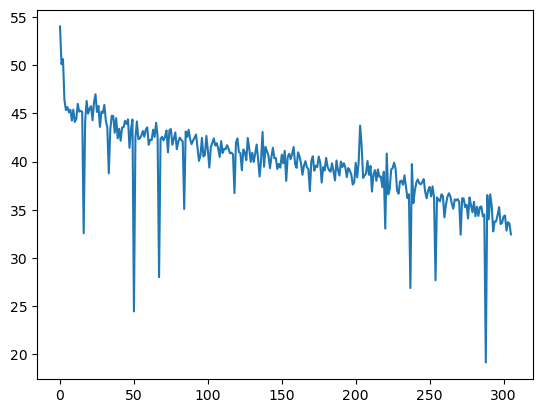

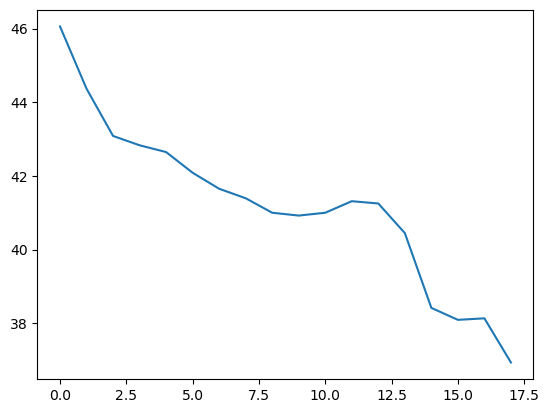

In [25]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()